# CS246 - Homework 1

## Question 4

### LSH for Approximate Near Neighbor Search

In [ ]:
!pip install -U -q PyDrive

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
id='1MzcgkUnI8HsPiQBf6hrwDKvsw3145eIH'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('patches.csv')

In [ ]:
import numpy as np
import random
import time
import pdb
import unittest
from PIL import Image
import math
import matplotlib.pyplot as plt
import matplotlib.image as pimg

In [ ]:
def l1(u, v):
    return np.sum(abs(u - v))

In [ ]:
def load_data(filename):
    return np.genfromtxt(filename, delimiter=',')

Creates a hash function from a list of dimensions and thresholds.

In [ ]:
def create_function(dimensions, thresholds):
    def f(v):
        boolarray = [v[dimensions[i]] >= thresholds[i] for i in range(len(dimensions))]
        return "".join(map(str, map(int, boolarray)))
    return f

In [ ]:
def create_functions(k, L, num_dimensions=400, min_threshold=0, max_threshold=255):
    functions = []
    for i in range(L):
        dimensions = np.random.randint(low = 0, 
                                   high = num_dimensions,
                                   size = k)
        thresholds = np.random.randint(low = min_threshold, 
                                   high = max_threshold + 1, 
                                   size = k)

        functions.append(create_function(dimensions, thresholds))
    return functions

In [ ]:
def hash_vector(functions, v):
    return np.array([f(v) for f in functions])

In [ ]:
def hash_data(functions, A):
    return np.array(list(map(lambda v: hash_vector(functions, v), A)))

In [ ]:
def get_candidates(hashed_A, hashed_point, query_index):
    return filter(lambda i: i != query_index and \
        any(hashed_point == hashed_A[i]), range(len(hashed_A)))

In [ ]:
def lsh_setup(A, k = 24, L = 10):
    functions = create_functions(k = k, L = L)
    hashed_A = hash_data(functions, A)
    return (functions, hashed_A)

Run the entire LSH algorithm

In [ ]:
def lsh_search(A, hashed_A, functions, query_index, num_neighbors = 10):
    hashed_point = hash_vector(functions, A[query_index, :])
    candidate_row_nums = get_candidates(hashed_A, hashed_point, query_index)
    
    distances = map(lambda r: (r, l1(A[r], A[query_index])), candidate_row_nums)
    best_neighbors = sorted(distances, key=lambda t: t[1])[:num_neighbors]

    return [t[0] for t in best_neighbors]

In [ ]:
#Hàm linear_search thực hiện tìm kiếm tuyến tính các hàng gần với hàng query_index nhất trong ma trận A
def linear_search(A, query_index, num_neighbors):
    all_neighbors = filter(lambda i: i != query_index, range(len(A)))
    distances = map(lambda r: (r, l1(A[r], A[query_index])), all_neighbors)
    best_neighbors = sorted(distances, key=lambda t: t[1])[:num_neighbors]

    return [t[0] for t in best_neighbors]

In [ ]:
#Hàm error dùng để tính toán độ chính xác của phương pháp tìm kiếm gần nhất của thuật toán LSH so với phương pháp tìm kiếm tuyến tính.
def error(A, k, L, indexes, nearestN):
    functions, hashed_A = lsh_setup(A, k, L)
    errors = []
    for query_index in indexes:
        lsh_nearests = lsh_search(A, hashed_A, functions, query_index, nearestN)
        ann_l1_dists = map(lambda r: l1(A[r], A[query_index]), lsh_nearests)
        ann_dist_sum = math.fsum(ann_l1_dists)     # math.fsum for precision
        lin_nearests = linear_search(A, query_index, nearestN)
        lin_l1_dists = map(lambda r: l1(A[r], A[query_index]), lin_nearests)
        lin_dist_sum = math.fsum(lin_l1_dists)
        errors.append( (1.0 * ann_dist_sum) / lin_dist_sum )
    return np.mean(errors)

In [ ]:
# color: 'bs-', 'g^-', 'ro-'
#Hàm plot_fig là một hàm vẽ biểu đồ sử dụng thư viện matplotlib
def plot_fig(xlabel, Xs, ylabel, Ys, color, title, legend, filename = None):
    plt.figure(figsize=(12,6))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.plot(Xs, Ys, color, label=legend)
    plt.legend(loc='lower right')
    if filename:
        plt.savefig(filename)
        plt.close(filename)
    else:
        plt.show()

In [ ]:
'''Hàm plot_sideByside() là một hàm để hiển thị các ảnh kề cận của một query image trong một bộ dữ liệu, cùng với ảnh query đó.
Hàm này sẽ trả về một biểu đồ bao gồm một hình ảnh query ở giữa và các hình ảnh kề cận nằm quanh nó. 
Các hình ảnh này sẽ được sắp xếp trong một lưới có n_row hàng và n_col cột, mỗi hình ảnh sẽ được hiển thị với kích thước h x w. 
Tiêu đề của mỗi hình ảnh sẽ chứa thông tin về chỉ số của ảnh và mô tả ngắn gọn (được truyền vào qua tham số subtitle), 
và các hình ảnh này sẽ được đánh số theo thứ tự các chỉ số được truyền vào qua danh sách nImages.'''
def plot_sideByside(As, qImage, nImages, subtitle, h, w, n_row=3, n_col=5, filename = None):
    nbrCnt = len(nImages)
    images = np.empty((nbrCnt+1, 20, 20))   
    titles = ['' for i in range(nbrCnt+1)]

    for i in range(nbrCnt):
        img = np.reshape(As[nImages[i], :], [20, 20])
        images[i,:,:] = img
        titles[i] = "near neighbor #" + str(i) + ", index: " + str(nImages[i]) + ' - ' + subtitle

    images[nbrCnt,:,:] = np.reshape(As[qImage, :], [20, 20])
    titles[nbrCnt] = "Query image, index" + str(qImage)

    plt.figure(figsize=(1.5 * n_col, 1.8 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    llen = 18
    for i in range(min(n_row * n_col, len(images))):
        plt.subplot(n_row, n_col, i+1)
        plt.imshow(images[i])
        title_i = titles[i]
        if len(title_i) >= llen:
            title_i = titles[i][:llen] + '\n' + titles[i][llen:]
        plt.title(title_i, size=7)
        plt.xticks(())
        plt.yticks(())

    if filename:
        plt.savefig(filename)
        plt.close()
    else:
        plt.show()

TODO: Write a function that computes the error measure

In [ ]:
#Hàm get_error dùng để tính toán tỷ lệ lỗi giữa phương pháp tìm kiếm hàng xóm gần nhất tuyến tính và phương pháp tìm kiếm LSH
def get_error(A, image_patches, linear_neighbors, lsh_neighbours):
    error_sum = 0
    for j in range(10):
        patch = image_patches[j]
        linear_distance = sum([l1(A[idx],A[patch]) for idx in linear_neighbors[j]])
        lsh_distance = sum([l1(A[idx],A[patch]) for idx in lsh_neighbours[j]])
        error_sum += lsh_distance/linear_distance
    return error_sum/10

TODO: Solve Problem 4

In [ ]:
# TODO: Solve Problem 4
'''Hàm problem4 thực hiện việc thử nghiệm và đánh giá kết quả của thuật toán LSH (Locality Sensitive Hashing) trong bài toán tìm kiếm hình ảnh. 
Cụ thể, hàm đọc dữ liệu ảnh từ tệp patches.csv, tạo bộ chỉ mục LSH và các hàm băm cần thiết từ các đặc trưng của ảnh, 
thực hiện tìm kiếm và so sánh kết quả giữa thuật toán LSH và tìm kiếm tuyến tính (linear search), 
tính toán thời gian chạy của hai phương pháp và vẽ đồ thị thể hiện sự phụ thuộc của lỗi và thời gian tìm kiếm vào các siêu tham số của LSH. 
Cuối cùng, hàm trực quan hóa 10 ảnh gần nhất tìm được bởi LSH và linear search cho một ảnh truy vấn.'''
def problem4():
    As = load_data('patches.csv')
    Qs = [100*i-1 for i in range(1,11)]

    funcs, hAs = lsh_setup(As)
    Ts_lsh = []
    Ts_lin = []
    top3n_lsh = []
    top3n_lin = []
    for query_index in Qs:
        sta = time.time()
        top3 = lsh_search(As, hAs, funcs, query_index, 3)
        end = time.time()
        top3n_lsh.append((query_index, top3))
        Ts_lsh.append((end-sta)*1000.0) 
        sta = time.time()
        top3 = linear_search(As, query_index, 3)
        end = time.time()
        top3n_lin.append((query_index, top3))
        Ts_lin.append((end-sta)*1000.0) 

    print('LSH search: (query_index, [top 3 near neighbors]):')
    for p in top3n_lsh:
        print(p)

    print

    print('Linear search: (query_index, [top 3 near neighbors]):')
    for p in top3n_lin:
        print(p)

    print

    meanStime_lsh = np.mean(Ts_lsh)
    meanStime_linear = np.mean(Ts_lin)
    print('Average Top 3 nearest neighbors LSH searching time: %0.3f (ms)' % (meanStime_lsh))
    print('Average Top 3 nearest neighbors Linear search time: %0.3f (ms)' % (meanStime_linear))

    print

    k = 24
    Ls = [10, 12, 14, 16, 18, 20]
    ks = [16, 18, 20, 22, 24]
    L = 10
    err_kLs = []
    err_ksL = []

    for Li in Ls:
        err_kLs.append(error(As, k, Li, Qs, 3))
    plot_fig('X axis - L values', Ls, 'Y axis - Errors (k = 24)', err_kLs, 'bs-', 'Errors vs. L (10,12,14,16,18,20)', 'k = 24', 'error-L.png')

    for ki in ks:
        err_ksL.append(error(As, ki, L, Qs, 3))
    plot_fig('X axis - k values', ks, 'Y axis - Errors (L = 10)', err_ksL, 'g^-', 'Errors vs. k (16,18,20,22,24)', 'L = 10', 'error-k.png')

    query_index = 99
    topN = 10
    funcs, hAs = lsh_setup(As)

    nbs = lsh_search(As, hAs, funcs, query_index, topN)
    plot_sideByside(As, query_index, nbs, 'LSH', 40, 40, n_row=3, n_col=5, filename = 'LSH-Top10.png')

    nbs = linear_search(As, query_index, topN)
    plot_sideByside(As, query_index, nbs, 'Linear', 40, 40, n_row=3, n_col=5, filename = 'Linear-Top10.png')


# TEST

In [ ]:
class TestLSH(unittest.TestCase):
    def test_l1(self):
        u = np.array([1, 2, 3, 4])
        v = np.array([2, 3, 2, 3])
        self.assertEqual(l1(u, v), 4)

    def test_hash_data(self):
        f1 = lambda v: sum(v)
        f2 = lambda v: sum([x * x for x in v])
        A = np.array([[1, 2, 3], [4, 5, 6]])
        self.assertEqual(f1(A[0,:]), 6)
        self.assertEqual(f2(A[0,:]), 14)

        functions = [f1, f2]
        self.assertTrue(np.array_equal(hash_vector(functions, A[0, :]), np.array([6, 14])))
        self.assertTrue(np.array_equal(hash_data(functions, A), np.array([[6, 14], [15, 77]])))

    ### TODO: Write your tests here (they won't be graded, 
    ### but you may find them helpful)
    def test_plot_fig(self):
        Epoch = [1,2,3,4,5,6,7,8,9]
        y = [0.1, 0.15, 0.05, 0.11, 0.16, 0.09, 0.11, 0.15, 0.16]
        plot_fig('x-epoch', Epoch, 'y-accuracy', y, 'bs-', 'Test plot', 'test legend', 'test-plot.png')

LSH search: (query_index, [top 3 near neighbors]):
(99, [38169, 11947, 23843])
(199, [39397, 23895, 30884])
(299, [51140, 8430, 6935])
(399, [13918, 17584, 24280])
(499, [19694, 17167, 50541])
(599, [59148, 54456, 1283])
(699, [50345, 31709, 40811])
(799, [56418, 55146, 11442])
(899, [40190, 45264, 31989])
(999, [46093, 28450, 59238])
Linear search: (query_index, [top 3 near neighbors]):
(99, [58690, 23633, 26168])
(199, [39397, 11341, 23895])
(299, [51140, 23097, 8430])
(399, [20536, 18874, 20572])
(499, [14552, 51717, 21520])
(599, [6201, 47784, 9540])
(699, [50345, 31709, 40811])
(799, [33741, 13889, 24319])
(899, [34377, 41365, 38565])
(999, [46093, 28450, 59238])
Average Top 3 nearest neighbors LSH searching time: 121.393 (ms)
Average Top 3 nearest neighbors Linear search time: 358.333 (ms)


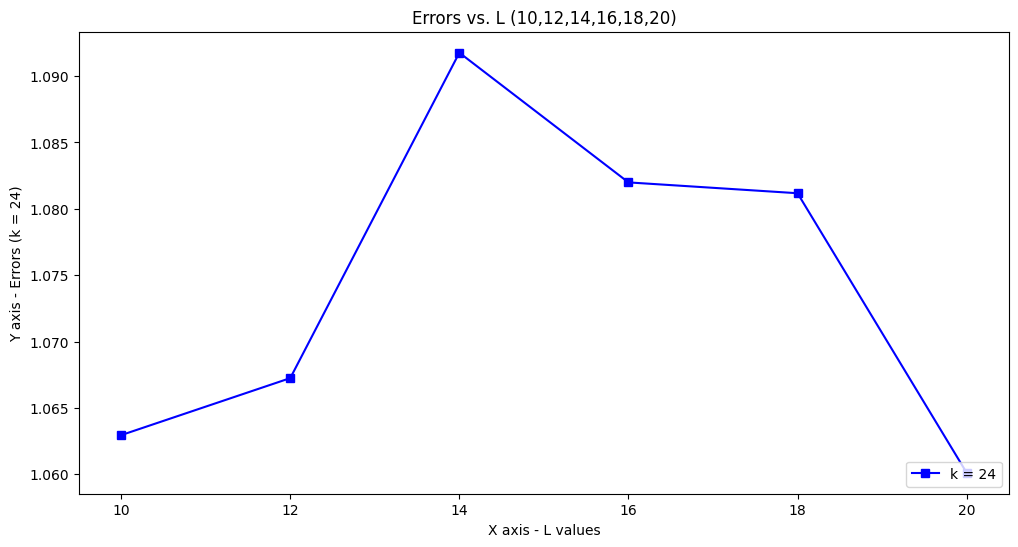

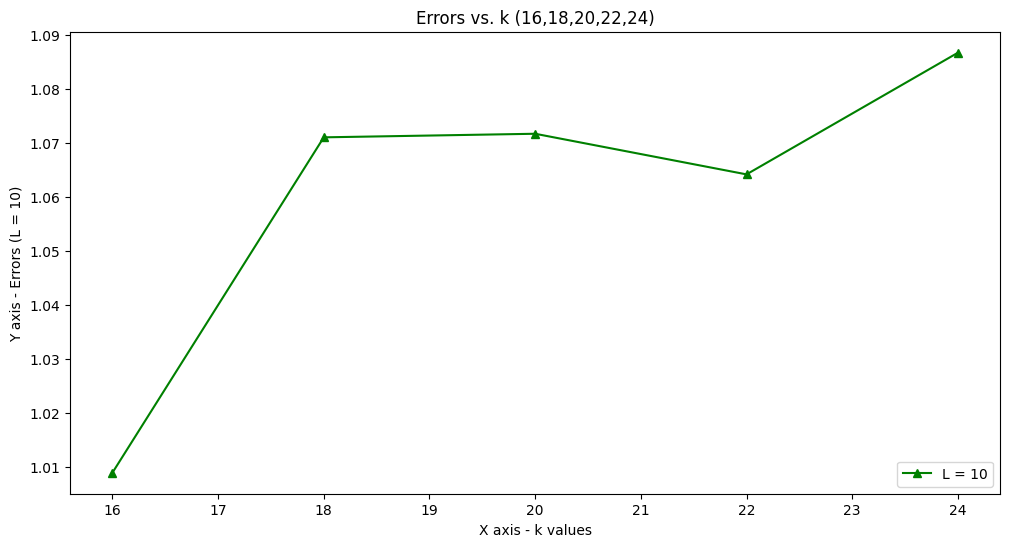

In [ ]:
if __name__ == '__main__':
    # unittest.main() # TODO: Uncomment this to run tests
    problem4()